In [1]:
import numpy as np # math calcuations and other matrix, vector processing
import pandas as pd # dataframe organization (similar to Excel)
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
from sklearn.preprocessing import StandardScaler #replace by MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train_csv = 'fashion_mnist_train.csv'
test_csv = 'fashion_mnist_test.csv'
feature_names = None #['pixel0, 'pixel1',...]
label_name = 'label'

In [54]:
# Read data
def read_data(csv_file):
    df = pd.read_csv(csv_file)
    return df

# process data
def get_features_labels(df, feature_names, label_name=None):
    if feature_names:
        X_features = df[feature_names].values
    elif label_name:
        X_features = df.drop(label_name, axis=1).values
    else:
        X_features = df.values
    y_labels = None
    if label_name: #have the label column in the dataframe
        y_labels = df[label_name].values
    return X_features, y_labels

# Normalize feature
def feature_normalization(X_train_features, X_test_features,
                          do_normalization=True):
    if do_normalization:
        scaler = StandardScaler()
        scaler.fit(X_train_features)
        X_train_scaled_features = scaler.transform(X_train_features)
        X_test_scaled_features = scaler.transform(X_test_features)
        return X_train_scaled_features, X_test_scaled_features
    else:
        return X_train_features, X_test_features

# Construct DNN model
def build_DNN_model(input_shape):
    model = Sequential()
    initializer_rn = \
        tf.keras.initializers.RandomNormal(stddev=0.01),
    initializer_vs = tf.keras.initializers.VarianceScaling(
        scale=0.1, mode='fan_in', distribution='uniform')
    initializer_gr = \
    tf.keras.initializers.GlorotNormal(seed=2022)
    initializer_he = tf.keras.initializers.HeNormal(seed=2022)

    l1_regularizer = tf.keras.regularizers.L1(0.01)
    l2_regularizer = tf.keras.regularizers.L2(0.01)
    
    model.add(layers.Dense(512, activation=None, 
        kernel_initializer=initializer_vs,                   
        kernel_regularizer=l2_regularizer,
                           input_shape=input_shape,                      
                          )) 
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activation='relu'))

    model.add(layers.Dense(64, activation='tanh'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

# train the model
def train_DNN(model, data, random_seed, **kwargs):
    seed = random_seed
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=3, 
        verbose=1,
        restore_best_weights=True                               
        )
    optimizer = kwargs['optimizer']
    epochs = kwargs['epochs']
    batch_size = kwargs['batch_size']
    model.compile(optimizer = optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
    history = model.fit(x=data['X_train'], y=data['y_train'], 
                    batch_size=batch_size,
                    validation_data=[data['X_val'], data['y_val']],
                    epochs=epochs,
                    callbacks=[callback],
                    verbose=1)
    return history
#plot loss/accuracy vals
def plot_train_val(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [4]:

# Read the data
df_train = read_data(train_csv)
df_test = read_data(test_csv)
X_train_features, y_train = \
        get_features_labels(df_train, 
                 feature_names=None, label_name=label_name)
X_test_features, _ = get_features_labels(df_test, 
                 feature_names=None, label_name=None)
X_train, X_test = feature_normalization(X_train_features, 
                                        X_test_features,
                          do_normalization=True)


In [5]:

# Construct validation data
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, stratify = y_train, test_size=0.3, 
    random_state=2022)



In [76]:
# Build and train DNN model
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",# loss, accuracy, val_accuracy
    patience=3,# after 3 epoch model witll stop if it does not see better performance
    verbose=1, 
    restore_best_weights=True,# false: use weights from the last epoch, #true: use weights that give best performance
)
model = build_DNN_model(X_train_[0].shape)
data = {'X_train': X_train, 'y_train': y_train,
        'X_val' : X_val, 'y_val': y_val}
model.summary()
model_parameters = {'batch_size': 16,
                    'optimizer': 'SGD',
                    'epochs': 5, 'verbose':1
                   }
                    
history = train_DNN(model, data,
                    random_seed=2022,
                    **model_parameters, callbacks = [callback]
                   )


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               401920    
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 64)                32832     
                                                                 
 dense_38 (Dense)            (None, 128)               8320      
                                                                 
 dense_39 (Dense)            (None, 10)                1290      
                                                     

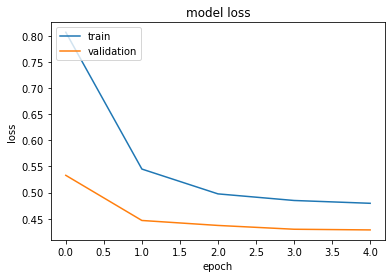

In [77]:

plot_train_val(history)

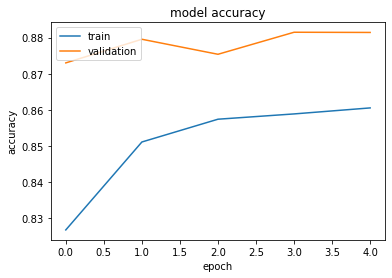

In [78]:
plot_accuracy(history)

In [79]:
# Check performance on test-train-split set:
#predicted score
y_pred_test = model.predict(X_val) #output of last layer
# predicted labels
y_pred_label_test = np.argmax(y_pred_test, axis=1)


print(f'Accuracy score = {accuracy_score(y_val,y_pred_label_test)}')


563/563 [==============================] - 4s 7ms/step
Accuracy score = 0.8814444444444445


In [80]:
# Save Predictions for Test Data
#predicted score
y_pred = model.predict(X_val) #output of last layer
# predicted labels
y_pred_label = np.argmax(y_pred, axis=1)

df_test_pred = pd.DataFrame(data=y_pred_label, columns=['label'])
df_test_pred.to_csv('fashion_prediction.csv')

563/563 [==============================] - 4s 7ms/step
